In [1]:
from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, Distance
from typing import List
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_qdrant import QdrantVectorStore
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import DirectoryLoader, CSVLoader
from langchain_core.documents import Document
from dotenv import load_dotenv
import os

In [2]:

folder_path='data'
db_path='db_qdrant'
url="https://5d9673e8-d966-4738-adbb-95a5842604ba.europe-west3-0.gcp.cloud.qdrant.io"
load_dotenv()
qdrant_key = os.getenv('qdrant_key')

In [3]:
def load_text(file_path):
    return CSVLoader(file_path=file_path,encoding='utf-8')

import re
from datetime import datetime

# Function to extract date or return current date if not present
def extract_date(text):
    # Split the text by newlines
    lines = text.strip().split("\n")
    
    # Check if the 3rd line exists
    if len(lines) >= 3:
        # Try to match a date pattern in the 3rd line (e.g., "19 August 2024")
        date_match = re.search(r'(\d{1,2} \w+ \d{4})', lines[2])
        if date_match:
            return date_match.group(1)  # Return the extracted date

    # If no date found, return the current date
    return datetime.now().strftime("%d %B %Y")

class AdvanceTextSplitter(RecursiveCharacterTextSplitter):
    def __init__(self, chunk_size=350, chunk_overlap=50, *args, **kwargs):
        super().__init__(chunk_size=chunk_size, chunk_overlap=chunk_overlap, *args, **kwargs)


    def remove_redundant_chunks(self, chunks: List[str]) -> List[str]:
        result=[]
        seen_chunks=set()
        idx=0
        for chunk in chunks:
            if chunk.page_content not in seen_chunks:
                chunk.id=idx
                result.append(chunk)
                seen_chunks.add(chunk.page_content)
                idx+=1
        return result
    def split_documents(self, documents: List[str]) -> List[str]:
        chunks=[]
        for doc in documents:
            curr_chunk = super().split_documents([doc])
            date=extract_date(doc.page_content)
            for chunk in curr_chunk:
                chunk.metadata['date']=date
            chunks.extend(curr_chunk)
        chunks = self.remove_redundant_chunks(chunks)
        
        return chunks

# # Load documents from the directory
# loader = DirectoryLoader(folder_path, glob="*.csv", loader_cls=load_text)
# documents = loader.load()
# # Split documents into chunks
# text_splitter = AdvanceTextSplitter(chunk_size=250, chunk_overlap=40)
# docs_from_crawl = text_splitter.split_documents(documents)
# print(docs_from_crawl[100].id)

In [3]:
def create_vector_db(chunks):
    # Generate embeddings
    model_name = "hiieu/halong_embedding"
    embeddings = HuggingFaceEmbeddings(model_name=model_name)
    # Create and configure Qdrant client
    client = QdrantClient(
        url=url, 
        api_key=qdrant_key,
    )
    print(client.get_collections())
    collection_name = "cmc_final_db"
    if not client.collection_exists(collection_name):
        client.create_collection(
            collection_name=collection_name,
            vectors_config=VectorParams(size=768, distance=Distance.COSINE),
        )
    # Store the chunks with summaries in the vector database

    number_points = client.count(collection_name).count
    print('current number of points:',number_points)
    next_ids=number_points+1

    desert_chunks=[ x for x in chunks if x.id>=next_ids]
    print('number points need to insert:',len(desert_chunks))
    vector_store = QdrantVectorStore(
        client=client,
        collection_name=collection_name,
        embedding=embeddings,
    )
    vector_store.add_documents(desert_chunks)

    print("Database created and documents added successfully.")
    return vector_store


# Call the function with the folder path
# db=create_vector_db(docs_from_crawl)


In [4]:
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['cmc_data_3']
collection = db['resource']

# Fetch all documents
documents = collection.find({})  # Adjust query if needed

# Convert MongoDB documents to the expected format
chunks = []
for doc in documents:
    # Assuming each document has an 'id' and 'page_content'
    chunk=Document(
        page_content=doc['page_content'],
        metadata= {key: value for key, value in doc.items() if key not in ['_id', 'id', 'page_content']}
    )
    chunk.id=doc['_id']
    chunks.append(chunk)
print('number of documents:', len(chunks))

number of documents: 39746


In [5]:
chunks[100]

Document(id=101, metadata={'date': '2024-11', 'source': 'Su ky CMC30.pdf'}, page_content='.Hình ảnh: Anh Nguyễn Trung Chính đứng  trước cửa Công ty TNHH HT&NT Hình ảnh: Số nhà 30 Lý Nam Đế.Từ những nhà nghiên cứu, những kỹ sư tin học của HT&NT trở thành  những người lắp ráp, sửa chữa và cung cấp máy tính.')

In [ ]:
for i in range(40):
    try:
        create_vector_db(chunks)
    except:
        pass

e:\Python\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange



collections=[CollectionDescription(name='cmc_final_db')]
current number of points: 37888
number points need to insert: 1858
collections=[CollectionDescription(name='cmc_final_db')]
current number of points: 38144
number points need to insert: 1602
collections=[CollectionDescription(name='cmc_final_db')]
current number of points: 38400
number points need to insert: 1346
collections=[CollectionDescription(name='cmc_final_db')]
current number of points: 39168
number points need to insert: 578
collections=[CollectionDescription(name='cmc_final_db')]
current number of points: 39168
number points need to insert: 578
collections=[CollectionDescription(name='cmc_final_db')]
current number of points: 39168
number points need to insert: 578
Database created and documents added successfully.
collections=[CollectionDescription(name='cmc_final_db')]
current number of points: 39746
number points need to insert: 0
Database created and documents added successfully.
collections=[CollectionDescription(

In [ ]:
diachi='Địa chỉ cmc ts: Hà Nội: Tầng 16, Tòa nhà CMC, Duy Tân, Quận Cầu Giấy, Hà Nội Điện thoại: +84 243 795 8686 | Fax: +84 237 958 383, Chi nhánh TP. Hồ Chí Minh: Tầng 9, Toà nhà CMC Creative Space, Đường 19A, KCX Tân Thuận, Quận 7, TP. Hồ Chí Minh'
client = QdrantClient(
    url=url, 
    api_key=qdrant_key,
)
print(client.get_collections())
diachi_doc=Document(page_content=diachi)
collection_name = "cmc_final_db"
number_points = client.count(collection_name).count
print(number_points)
dis_list=[diachi_doc]
for idx,curr_chunk in enumerate(dis_list):
    curr_chunk.id=idx+number_points

collections=[]


UnexpectedResponse: Unexpected Response: 404 (Not Found)
Raw response content:
b'{"status":{"error":"Not found: Collection `cmc_final_db` doesn\'t exist!"},"time":0.000030793}'

In [21]:
create_vector_db(dis_list)

collections=[CollectionDescription(name='cmc_corp_full_web'), CollectionDescription(name='cmc_corp_full_web_2')]
29621
1
Database created and documents added successfully.


In [6]:
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['cmc_data']
collection = db['cmcati']

# Retrieve document sizes
sizes = [doc['page_size'] for doc in collection.find({}, {'page_size': 1})]
print(len(sizes))

documents = collection.find({}, {'page_content': 1, 'size': 1})
docs_list=[Document(page_content=doc['page_content']) for doc in documents]
print(docs_list[0])
client = QdrantClient(
    url=url, 
    api_key=qdrant_key,
)
print(client.get_collections())
collection_name = "cmc_corp_full_web_2"
number_points = client.count(collection_name).count
print(number_points)
for idx,curr_chunk in enumerate(docs_list):
    curr_chunk.id=idx+number_points

94
page_content='TH Group hợp tác với CMC tiên phong ứng dụng AI vào hệ thống quản lý nhân sự 09/10/2024'
collections=[CollectionDescription(name='cmc_corp_full_web'), CollectionDescription(name='cmc_corp_full_web_2')]
29527


In [9]:
print(docs_list[50].id)

29577


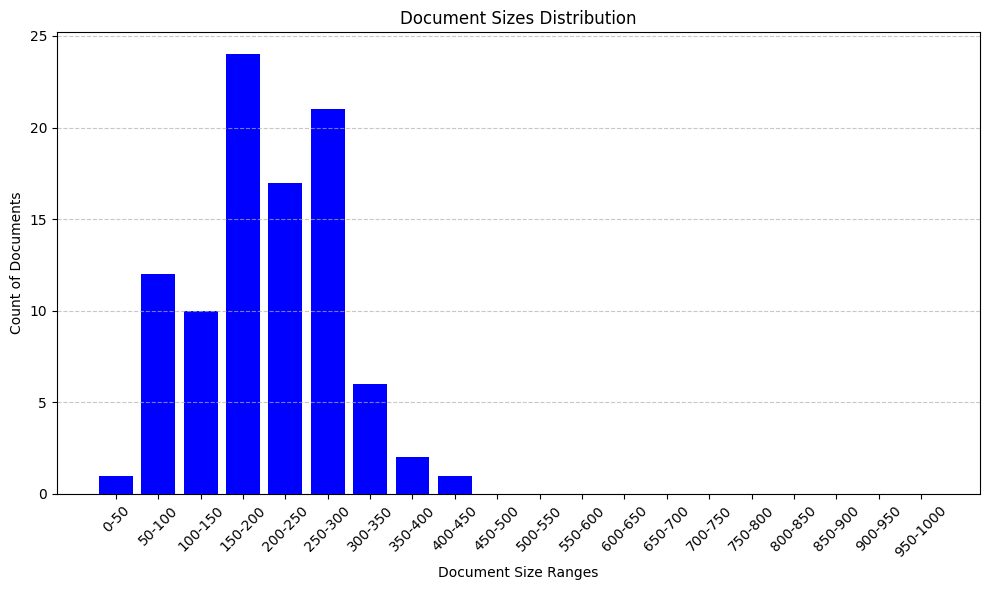

In [10]:
import numpy as np
import pandas as pd

# Define the bins
bins = np.arange(0, 1001, 50)  # Adjust range and step size as needed

# Create a DataFrame to count sizes in each bin
size_counts, bin_edges = np.histogram(sizes, bins=bins)

# Convert to a DataFrame for easier plotting
size_data = pd.DataFrame({
    'bin_range': [f'{bin_edges[i]}-{bin_edges[i + 1]}' for i in range(len(size_counts))],
    'count': size_counts
})
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(size_data['bin_range'], size_data['count'], color='blue')
plt.xlabel('Document Size Ranges')
plt.ylabel('Count of Documents')
plt.title('Document Sizes Distribution')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


In [11]:
create_vector_db(docs_list)

d:\python\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


collections=[CollectionDescription(name='cmc_corp_full_web'), CollectionDescription(name='cmc_corp_full_web_2')]
29527
Database created and documents added successfully.
